# Проект e-commerce
### Проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?  

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. 

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. 

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Файлы:

olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

%matplotlib inline 

In [5]:
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_items = pd.read_csv('olist_order_items_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')

In [6]:
#перед джоином проверяем датафреймы
print('Количиство строк и столбцов =',df_customers.shape, 'Типы колонок',df_customers.dtypes, sep='\n')
print('Количиство строк и столбцов =',df_items.shape, 'Типы колонок',df_items.dtypes, sep='\n')
print('Количиство строк и столбцов =',df_orders.shape, 'Типы колонок',df_orders.dtypes, sep='\n')


Количиство строк и столбцов =
(99441, 5)
Типы колонок
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object
Количиство строк и столбцов =
(112650, 7)
Типы колонок
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object
Количиство строк и столбцов =
(99441, 8)
Типы колонок
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object


In [7]:
#проверяем колонки на уникальные значения
print('df_customers', df_customers.customer_id.nunique())
print('df_orders', df_orders.customer_id.nunique())
print('df_orders', df_orders.order_id.nunique())
print('df_items', df_items.order_id.nunique())

df_customers 99441
df_orders 99441
df_orders 99441
df_items 98666


In [8]:
#проверяем колонки на пропущеные значения
print('df_items',df_items.isna().count(), sep='\n')
print('df_orders',df_orders.isna().count(), sep='\n')
print('df_customers',df_customers.isna().count(), sep='\n')


df_items
order_id               112650
order_item_id          112650
product_id             112650
seller_id              112650
shipping_limit_date    112650
price                  112650
freight_value          112650
dtype: int64
df_orders
order_id                         99441
customer_id                      99441
order_status                     99441
order_purchase_timestamp         99441
order_approved_at                99441
order_delivered_carrier_date     99441
order_delivered_customer_date    99441
order_estimated_delivery_date    99441
dtype: int64
df_customers
customer_id                 99441
customer_unique_id          99441
customer_zip_code_prefix    99441
customer_city               99441
customer_state              99441
dtype: int64


In [9]:
#мерджим дату и проверяем все ли ок
df = df_orders.merge(df_customers,how = 'left', on = 'customer_id' ) \
              .merge(df_items,how = 'inner',  on = 'order_id')
print('Количиство строк и столбцов =',df.shape, 'Типы колонок',df.dtypes, sep='\n')
df.head()

Количиство строк и столбцов =
(112650, 18)
Типы колонок
order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
order_item_id                      int64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
dtype: object


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [10]:
#базовая проверка на непротиворечивость данных
df.describe()

,customer_zip_code_prefix,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000,112650.000000
mean,35119.309090,1.197834,120.653739,19.990320
std,29866.120801,0.705124,183.633928,15.806405
min,1003.000000,1.000000,0.850000,0.000000
25%,11310.000000,1.000000,39.900000,13.080000
50%,24340.000000,1.000000,74.990000,16.260000
75%,59028.750000,1.000000,134.900000,21.150000
max,99990.000000,21.000000,6735.000000,409.680000


<AxesSubplot:>

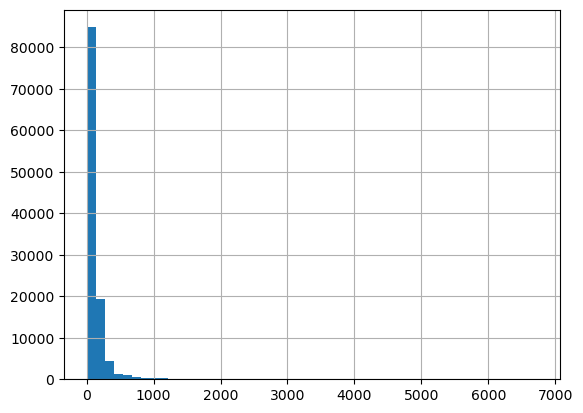

In [11]:
df.price.hist(bins = 50)

Здесь и в describe видим что средний прайс в районе 100, но есть большое макс значение

<AxesSubplot:>

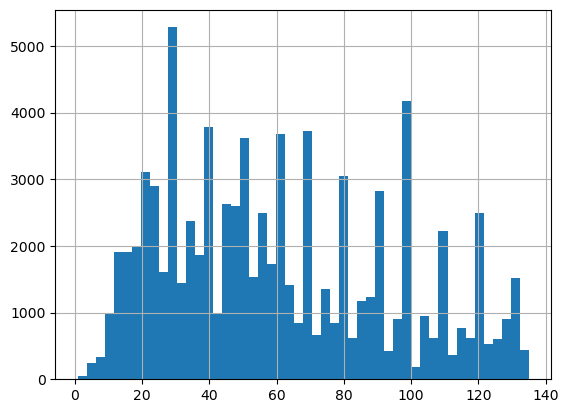

In [12]:
df.query('price < 135')['price'].hist(bins = 50)

Отрезали верхних 25% чтобы график давал чуть больше информации. Распределение напоминает uniform

In [13]:
print(df.order_purchase_timestamp.min())
print(df.order_purchase_timestamp.max())

2016-09-04 21:15:19
2018-09-03 09:06:57


In [14]:
df.order_status.value_counts()

delivered      110197
shipped          1185
canceled          542
invoiced          359
processing        357
unavailable         7
approved            3
Name: order_status, dtype: int64

In [15]:
df.order_status.value_counts(normalize = True)

delivered      0.978225
shipped        0.010519
canceled       0.004811
invoiced       0.003187
processing     0.003169
unavailable    0.000062
approved       0.000027
Name: order_status, dtype: float64

<AxesSubplot:>

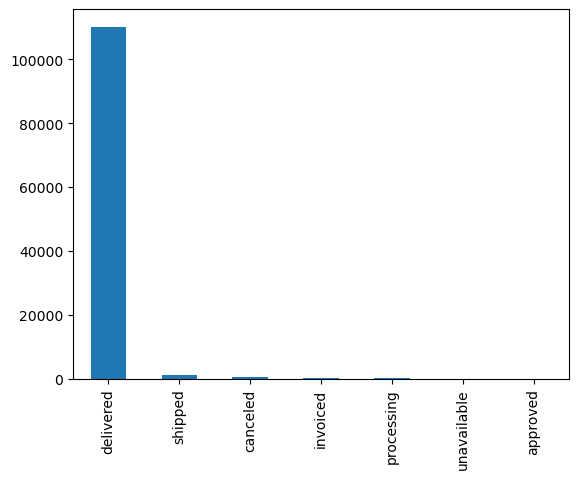

In [16]:
df.order_status.value_counts().plot(kind = 'bar')

In [17]:
df.query('order_status == "canceled"')['price'].describe()

count     542.000000
mean      175.710830
std       323.313746
min         5.530000
25%        38.127500
50%        82.445000
75%       179.975000
max      2649.000000
Name: price, dtype: float64

У нас 542 отмененных заказа, можем посмотреть сколько мы теряем денег. Отменено всего пол процента из всех заказов, но изучить не помешает

<AxesSubplot:>

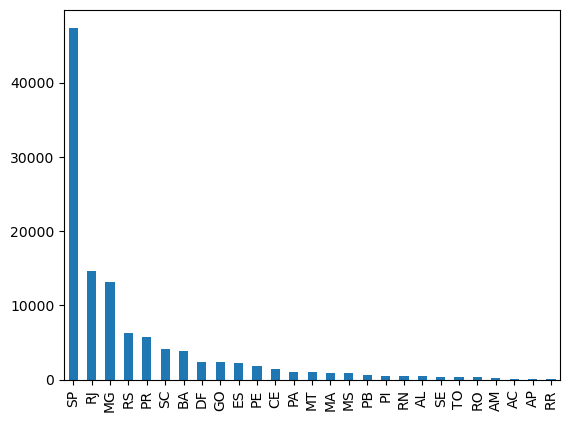

In [18]:
df.customer_state.value_counts().plot(kind = 'bar')

In [19]:
df.customer_state.value_counts()

SP    47449
RJ    14579
MG    13129
RS     6235
PR     5740
SC     4176
BA     3799
DF     2406
GO     2333
ES     2256
PE     1806
CE     1478
PA     1080
MT     1055
MA      824
MS      819
PB      602
PI      542
RN      529
AL      444
SE      385
TO      315
RO      278
AM      165
AC       92
AP       82
RR       52
Name: customer_state, dtype: int64


### ЗАДАНИЕ 1. Сколько у нас пользователей, которые совершили покупку только один раз?
 * за совершение покупки буду считать время подтверждения оплаты заказа(order_approved_at), тк это, как правило, данные из банка. 
 * order_status, скорее всего, выставляется внутри компании

In [20]:
# преобразуем колонки в нужный тип
df[["order_purchase_timestamp","order_approved_at"]] = df[["order_purchase_timestamp","order_approved_at"]]\
    .apply(pd.to_datetime)
# создадим датафрейм для id сделавших один заказ
# сначала оставляем нужные даты, группируем по уник id, считаем кол-во покупок на уник id, отсекаем всех, кто купил больше 1 раза
one_purchase = df.query('order_approved_at > "2016-09-14" and order_approved_at < "2018-09-04"')\
                 .groupby('customer_unique_id', as_index = False) \
                 .agg({'order_id' : 'nunique'}) \
                 .query('order_id == 1') \
                 .rename(columns = {'order_id' : 'one_purchase'})
print('Кол-во пользователей, которые совершили одну покупку =' ,one_purchase.one_purchase.sum())
one_purchase.head()

Кол-во пользователей, которые совершили одну покупку = 92495


,customer_unique_id,one_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


### ЗАДАНИЕ 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

* Создадим колонку с месяцем заказа
* Отберем нужные нам статусы
* Посчитаем среднее за месяц

In [21]:
# колонка с месяцем заказа
df['order_month'] = df.order_approved_at.dt.month_name() 

In [22]:
month_mean = df.query('order_status == "canceled" or order_status == "unavailable" ')\
               .groupby(['order_status','order_month'],as_index = False)\
               .agg({'order_id': 'nunique'}) \
               .groupby('order_status') \
               .agg({'order_id' : 'mean'}) \
               .rename(columns = {'order_id' : 'mean_month_fail'})

print('Статус заказа - недоступен:', month_mean.iloc[1, 0])
print('Статус заказа - отменен:', month_mean.iloc[0, 0])
month_mean

Статус заказа - недоступен: 6.0
Статус заказа - отменен: 38.416666666666664


,mean_month_fail
order_status,
canceled,38.416667
unavailable,6.000000


Можем еще посчитать отмены по каждому меесяцу и создать колонку diff с разницей месяца и среднего за год

In [23]:
every_month_cancel = df.query('order_status == "canceled" or order_status == "unavailable" ')\
                       .groupby(['order_status','order_month'],as_index = False)\
                       .agg({'order_id': 'nunique'})
every_month_cancel['diff'] = month_mean.iloc[0, 0] - every_month_cancel.query('order_status == "canceled"').order_id
every_month_cancel

,order_status,order_month,order_id,diff
0,canceled,April,27,11.416667
1,canceled,August,53,-14.583333
2,canceled,December,7,31.416667
3,canceled,February,86,-47.583333
4,canceled,January,34,4.416667
5,canceled,July,62,-23.583333
6,canceled,June,29,9.416667
7,canceled,March,44,-5.583333
8,canceled,May,40,-1.583333
9,canceled,November,29,9.416667


Обращаем внимание что unavailable было только в октябре

In [24]:
df.query('order_status == "unavailable"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_month
37563,dc18a044b56ed174037ca164cdf2e921,4a06381959b6670756de02e07b83815f,unavailable,2016-10-05 14:16:28,2016-10-06 15:56:49,NaN,NaN,2016-11-29 00:00:00,b92a2e5e8a6eabcc80882c7d68b2c70b,6730,vargem grande paulista,SP,1,faa268ecc8a8434cb4ebee091b3222d6,f0563bacf40c311f1c4d3d6b67b8a7a7,2016-10-21 16:18:52,1199.00,28.78,October
57385,4dd47e84e6b8ff4a63d0b8425e6d788e,96bbcbc8372c86da857d842dfda6bd72,unavailable,2016-10-06 23:49:18,2016-10-07 01:09:08,NaN,NaN,2016-11-24 00:00:00,e347a8d0bfec0255258cc913ed28d3a9,28010,campos dos goytacazes,RJ,1,2aa489c905e1d41d8c716a6d6912d8c2,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 01:09:09,299.90,13.68,October
68759,3c3ca08854ca922fe8e9cedfd6841c8a,88c36fbd3df96094f90f0315e1d2dd90,unavailable,2016-10-08 12:13:38,2016-10-08 13:21:35,NaN,NaN,2016-11-30 00:00:00,e629cd3ff381ad0a234016fa7dd76f46,8610,suzano,SP,1,ac6c24af9f913c9375a3ea77883bda6e,5206cc4bc2297c833e6061c49bf9c43f,2016-10-12 13:21:35,35.00,10.96,October
70666,54bb06e1ca86bd99ee2a8d6288bf4ede,98bfbf477ed9f40a0264f5e527a446be,unavailable,2016-10-06 13:38:39,2016-10-06 14:22:19,NaN,NaN,2016-12-12 00:00:00,8aa802da0f525a68e7fae5e67929ebdd,18147,aracariguama,SP,1,bef13288a0f8b26d763411ced1dfa268,cf281cf8b7affbdfe751b29cc85580e1,2016-10-29 09:43:46,64.90,25.33,October
89694,1a47da1d66c70489c8e35fe2b5433ab7,3d8e326c3cef3a9bba7ca121baac5fc3,unavailable,2016-10-07 18:16:31,2016-10-07 18:53:48,NaN,NaN,2016-12-07 00:00:00,b18b6d40c3c5510727e0f22b568d3e1f,91430,porto alegre,RS,1,eba7488e1c67729f045ab43fac426f2e,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 18:53:48,249.90,20.85,October
94645,2fd1c83dd4714cf3cf796fffb6c8de62,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-05 17:21:29,2016-10-06 15:55:40,NaN,NaN,2016-11-29 00:00:00,30fceee7cb0dbe6926f2b1128f2b3648,31910,belo horizonte,MG,1,17c7ec33a1657924ad493e6978b4bf91,3d01d1c414c44b5943a09619ff3853cb,2016-10-10 15:55:42,99.00,9.12,October
94646,2fd1c83dd4714cf3cf796fffb6c8de62,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-05 17:21:29,2016-10-06 15:55:40,NaN,NaN,2016-11-29 00:00:00,30fceee7cb0dbe6926f2b1128f2b3648,31910,belo horizonte,MG,2,966a067b38634929844120e39b1576bc,61f159ef6da2d441951d2c0efa719362,2016-10-10 15:55:41,59.99,24.08,October


Ничего общего нету у этих заказов, видимо сбой на сайте на 3 дня с 2016-10-05 по 2016-10-08

______
#### ЗАДАНИЕ 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [25]:
#создаем колонку с днем заказа
df['order_day'] = df.order_purchase_timestamp.dt.day_name()
# группируем по дню недели и id товара, считаем кол-во покупок
day_buy = df.groupby(['product_id', 'order_day'], as_index = False) \
            .agg({'order_approved_at': 'count'}) \
            .groupby('product_id', as_index = False) \
            .agg(pd.Series.mode) \
            .rename(columns={'order_day':'popular_day'})
day_buy.head()

,product_id,popular_day,order_approved_at
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]",1
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1


Так как один товар одинаково популяен и в среду, и в пятницу, то используем моду

________
#### ЗАДАНИЕ 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [26]:
#создаем колоку с точным значением недель в месяц
df['avg_week'] = df.order_purchase_timestamp.dt.days_in_month / 7

In [27]:
avg_week= df.groupby(['customer_unique_id', 'avg_week'], as_index = False) \
            .agg({'order_approved_at': 'count'}) \
            .rename(columns={'order_approved_at':'total_orders'})
avg_week['avg_purchase'] = avg_week['total_orders'] / df['avg_week']          
avg_week.tail()

,customer_unique_id,avg_week,total_orders,avg_purchase
96503,fffcf5a5ff07b0908bd4e2dbc735a684,4.285714,2,0.466667
96504,fffea47cd6d3cc0a88bd621562a9d061,4.428571,1,0.225806
96505,ffff371b4d645b6ecea244b27531430a,4.000000,1,0.233333
96506,ffff5962728ec6157033ef9805bacc48,4.428571,1,0.225806
96507,ffffd2657e2aad2907e67c3e9daecbeb,4.428571,1,0.233333


In [28]:
avg_week.avg_purchase.describe()

count    96508.000000
mean         0.268660
std          0.135893
min          0.000000
25%          0.225806
50%          0.225806
75%          0.233333
max          5.419355
Name: avg_purchase, dtype: float64

В среднем совершается 0.26 покупки на пользователя

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


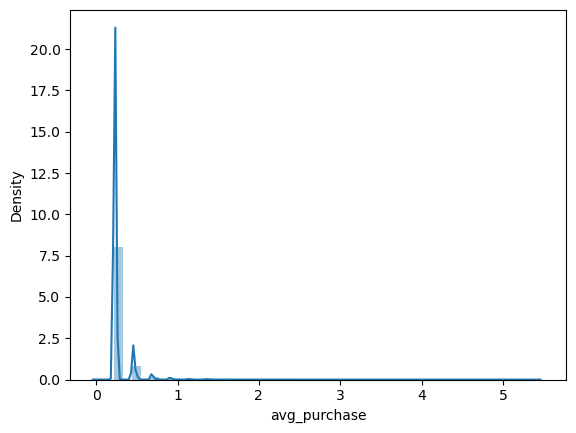

In [29]:
sns.distplot(avg_week.avg_purchase, hist_kws={"range": [0,5.5]});

Мы видим что 25-75 процентиль имеет практически идентичные числа

<AxesSubplot:>

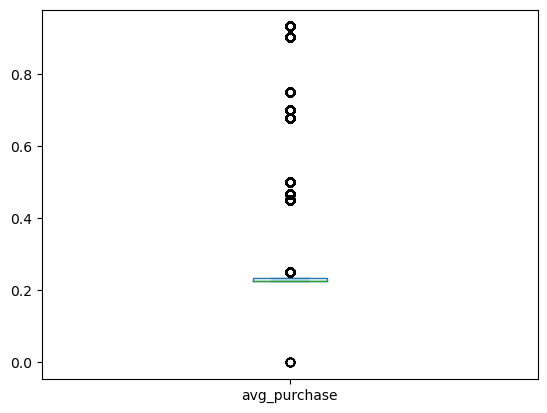

In [30]:
avg_week.query('avg_purchase < 1').avg_purchase.plot(kind = 'box')

Даже если отсечь все до единицы, то все равно на боксплоте ничего н понятно

____
#### ЗАДАНИЕ 5 
* Bспользуя pandas, проведи когортный анализ пользователей. 
* В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [31]:
# функция для получения нужного формата даты 
def get_month(x):
    return dt.datetime(x.year, x.month, 1)
#применям функцию  
df['invoice_month'] = df['order_purchase_timestamp'].apply(get_month)

#создаем колонку для первого заказа клиента
df['cohort_month'] = df.groupby('customer_unique_id')['invoice_month'].transform(min)

#создаем функцию для получения даты
def get_date(df, column):
    day = df[column].dt.day
    month = df[column].dt.month
    year = df[column].dt.year
    return day, month, year

#разбиваем данные для создания индекса когорт
_, invoice_month, invoice_year = get_date(df, 'invoice_month')
_, cohort_month, cohort_year = get_date(df, 'cohort_month')

#создаем когортный индекс вычитанием из последнего заказа первого
#индекс равен кол-ву месяцев, тк у нас помесячный анализ. 
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month
df['cohort_index'] = year_diff*12 + month_diff +1 #делаем +1, тк часто совпадает invoice_month и cohort_month, чтобы не получить 0
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,seller_id,shipping_limit_date,price,freight_value,order_month,order_day,avg_week,invoice_month,cohort_month,cohort_index
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,October,Monday,4.428571,2017-10-01,2017-09-01,2
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,July,Tuesday,4.428571,2018-07-01,2018-07-01,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,August,Wednesday,4.428571,2018-08-01,2018-08-01,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,November,Saturday,4.285714,2017-11-01,2017-11-01,1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,February,Tuesday,4.000000,2018-02-01,2018-02-01,1


In [32]:
# группируем дату для пивот таблицы по индекс, месяцу и считаем уник ID
cohort_data = df.groupby(['cohort_month','cohort_index'])['customer_unique_id'].nunique().reset_index()
cohort_data.head()

,cohort_month,cohort_index,customer_unique_id
0,2016-09-01,1,3
1,2016-10-01,1,305
2,2016-10-01,7,1
3,2016-10-01,10,1
4,2016-10-01,12,1


In [33]:
#создаем пивот таблицу для 2017г
retention = cohort_data.query('cohort_month > "2016-12-01" and cohort_month < "2018-01-01" ') \
                       .pivot(index = 'cohort_month', columns = 'cohort_index', values = 'customer_unique_id')
retention

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20
cohort_month,,,,,,,,,,,,,,,,,,,
2017-01-01,754.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02-01,1705.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,4.0,NaN
2017-03-01,2595.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN
2017-04-01,2339.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,4.0,NaN,NaN
2017-05-01,3560.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,9.0,10.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN
2017-06-01,3114.0,15.0,11.0,12.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN
2017-07-01,3843.0,20.0,14.0,9.0,11.0,8.0,12.0,4.0,7.0,10.0,8.0,11.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN
2017-08-01,4149.0,28.0,14.0,11.0,15.0,22.0,12.0,11.0,6.0,6.0,10.0,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,4090.0,28.0,22.0,12.0,18.0,9.0,9.0,10.0,12.0,7.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='cohort_index', ylabel='cohort_month'>

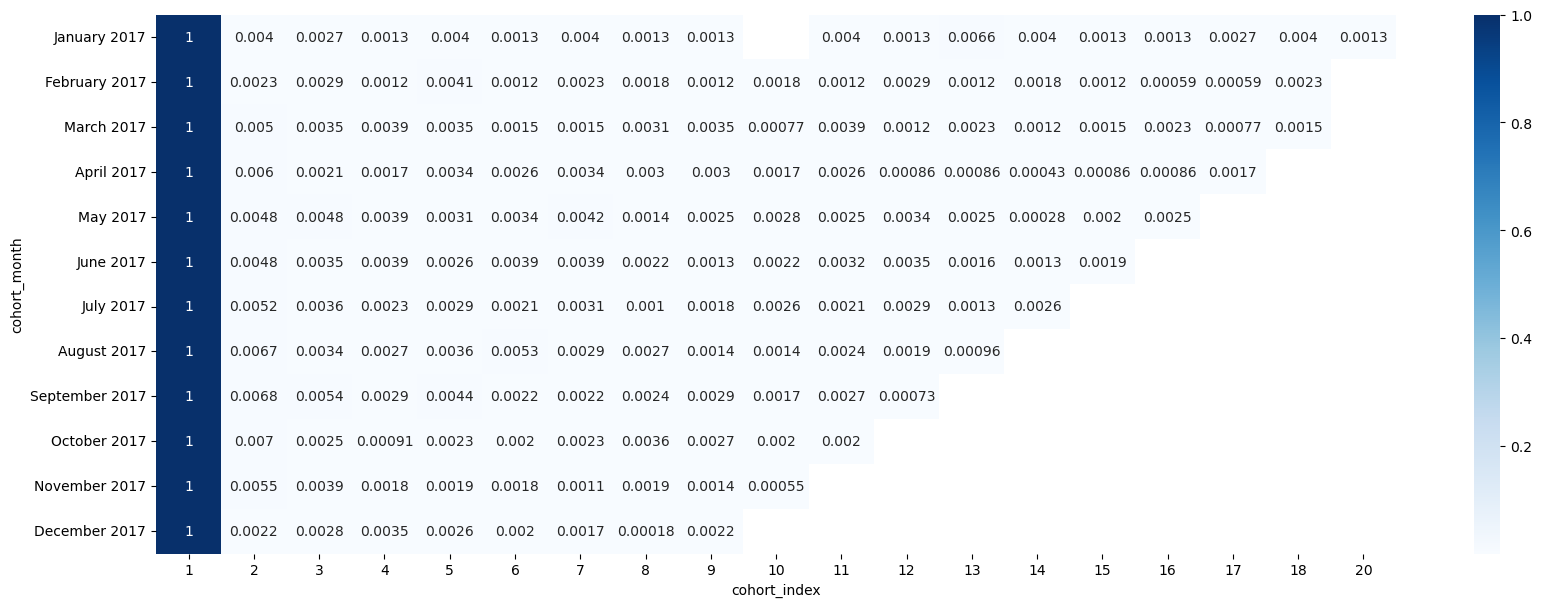

In [34]:
#переводим таблицу в проценты для удобства понимания
retention = retention.divide(retention.iloc[:,0], axis=0)
#переименовываем индкексы
retention.index = retention.index.strftime('%B %Y')
#создаем визуализацию
plt.figure(figsize = (20,7))
sns.heatmap(retention, annot = True, cmap= 'Blues')

* самый высокий ретеншн на третий месяц выходит у клиентов, впервые пришедших в снтябре 2017
* в принципе ретеншн очень невысокий, но сложно судить не зная специфику бизнеса

_____
#### Задание 6. 
Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
В кластеризации можешь выбрать следующие метрики: 
* R - время от последней покупки пользователя до текущей даты
* F - суммарное количество покупок у пользователя за всё время
* M - сумма покупок за всё время

Для кластеризации будем пользоваться библиотекой sklearn, методом KMeans

In [35]:
#группируем по id и времени подтверждения заказа. сумма нужна для monetary, кол-во для frequency 
rfm = df.groupby(['order_id','order_approved_at'])['price'].agg(['sum', 'count']).reset_index()
#для recency берем макс дату заказа и переводим в инт16 для подсчета
last_buy_time = (max(rfm['order_approved_at']) + timedelta(days = 1))
rfm['last_buy_time'] = rfm['order_approved_at'].apply(lambda x:last_buy_time - x)
rfm['last_buy_time']  = rfm['last_buy_time'].dt.days.astype('int16')
#переимновываем для наглядности
rfm = rfm.rename(columns = {'sum':'tot_sum', 'count':'tot_number_of_purchases'})
rfm

,order_id,order_approved_at,tot_sum,tot_number_of_purchases,last_buy_time
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 09:45:35,58.90,1,356
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 11:05:13,239.90,1,496
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:48:30,199.00,1,233
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:10:18,12.99,1,27
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 14:10:13,199.90,1,577
...,...,...,...,...,...
98647,fffc94f6ce00a00581880bf54a75a037,2018-04-25 04:11:01,299.99,1,132
98648,fffcd46ef2263f404302a634eb57f7eb,2018-07-17 04:31:48,350.00,1,49
98649,fffce4705a9662cd70adb13d4a31832d,2017-10-24 17:14:25,99.90,1,315
98650,fffe18544ffabc95dfada21779c9644f,2017-08-15 00:04:32,55.99,1,385


In [60]:
from sklearn.cluster import KMeans
pd.options.mode.chained_assignment = None 

Через KMeans проведем кластеризацию и определим самое подходящее кол-во кластеров для каждой категории
- recency
- frequency 
- monetary 

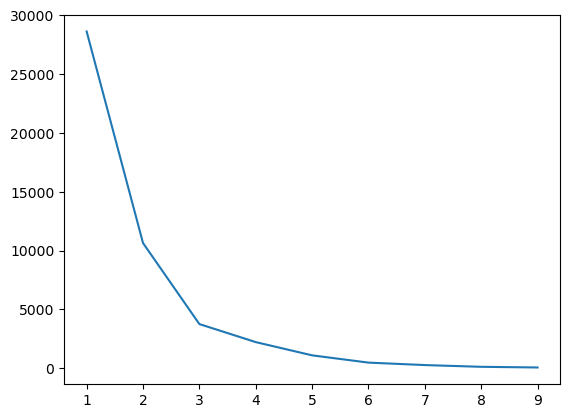

In [63]:
#сумма квадратов ошибок
sse = {}

rmf_recency = rfm[['tot_number_of_purchases']]

for k in range (1,10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(rmf_recency)
    rmf_recency['clusters'] = kmeans.labels_
#names for clusters
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.show();

In [41]:
#выбираем делить на 3 кластера и фит.предикт
kmeans = KMeans(n_clusters = 3)
rfm['recency_cluster'] = kmeans.fit_predict(rfm[['tot_number_of_purchases']])

NameError: name 'x' is not defined

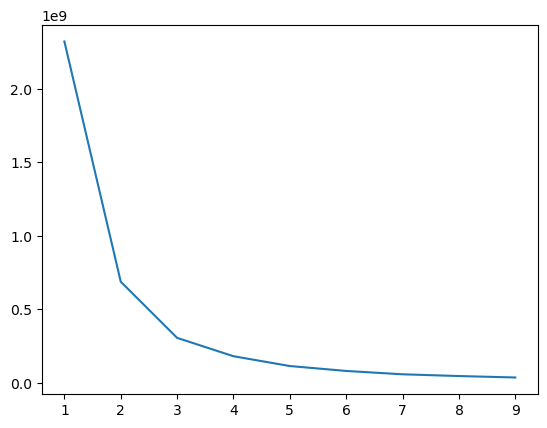

In [64]:
sse = {}
rmf_frequency = rfm[['last_buy_time']]

for k in range (1,10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(rmf_frequency)
    rmf_recency['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.show()

In [46]:
#выбираем делить на 3 кластера и фит.предикт
kmeans = KMeans(n_clusters = 3)
rfm['frequency_cluster'] = kmeans.fit_predict(rfm[['last_buy_time']])

NameError: name 'x' is not defined

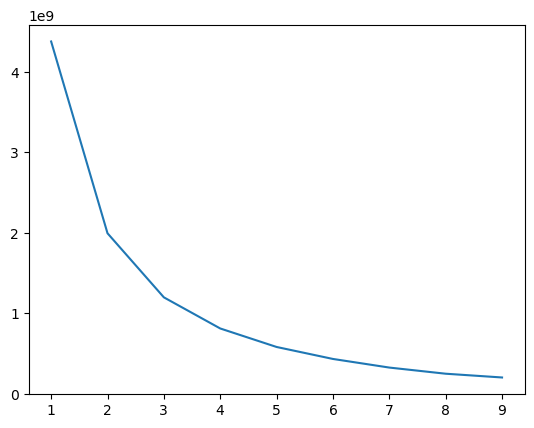

In [65]:
sse = {}
rmf_monetary = rfm[['tot_sum']]

for k in range (1,10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(rmf_monetary)
    rmf_recency['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.show()

In [ ]:
#выбираем делить на 3 кластера и фит.предикт
kmeans = KMeans(n_clusters = 4)
rfm['monetary_cluster'] = kmeans.fit_predict(rfm[['tot_sum']])

Воспользуемся двумя методами:
- Сумма трех скоров и разбиение на группы
- Конкатенация трех скоров и разбиение

In [66]:
rfm['sum_cluster'] = rfm['recency_cluster'] + rfm['frequency_cluster'] + rfm['monetary_cluster']

In [67]:
# создаем колонку rfm и соединяем туда все наши скоры
rfm['compile_cluster'] = rfm.apply(lambda x: str(x['recency_cluster']) + str(x['frequency_cluster']) + str(x['monetary_cluster']), axis=1 )
rfm.head()

,order_id,order_approved_at,tot_sum,tot_number_of_purchases,last_buy_time,recency_cluster,frequency_cluster,monetary_cluster,sum_cluster,compile_cluster
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 09:45:35,58.90,1,356,0,0,2,2,002
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 11:05:13,239.90,1,496,0,2,2,4,022
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:48:30,199.00,1,233,0,0,2,2,002
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:10:18,12.99,1,27,0,1,2,3,012
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 14:10:13,199.90,1,577,0,2,2,4,022


<AxesSubplot:xlabel='count', ylabel='sum_cluster'>

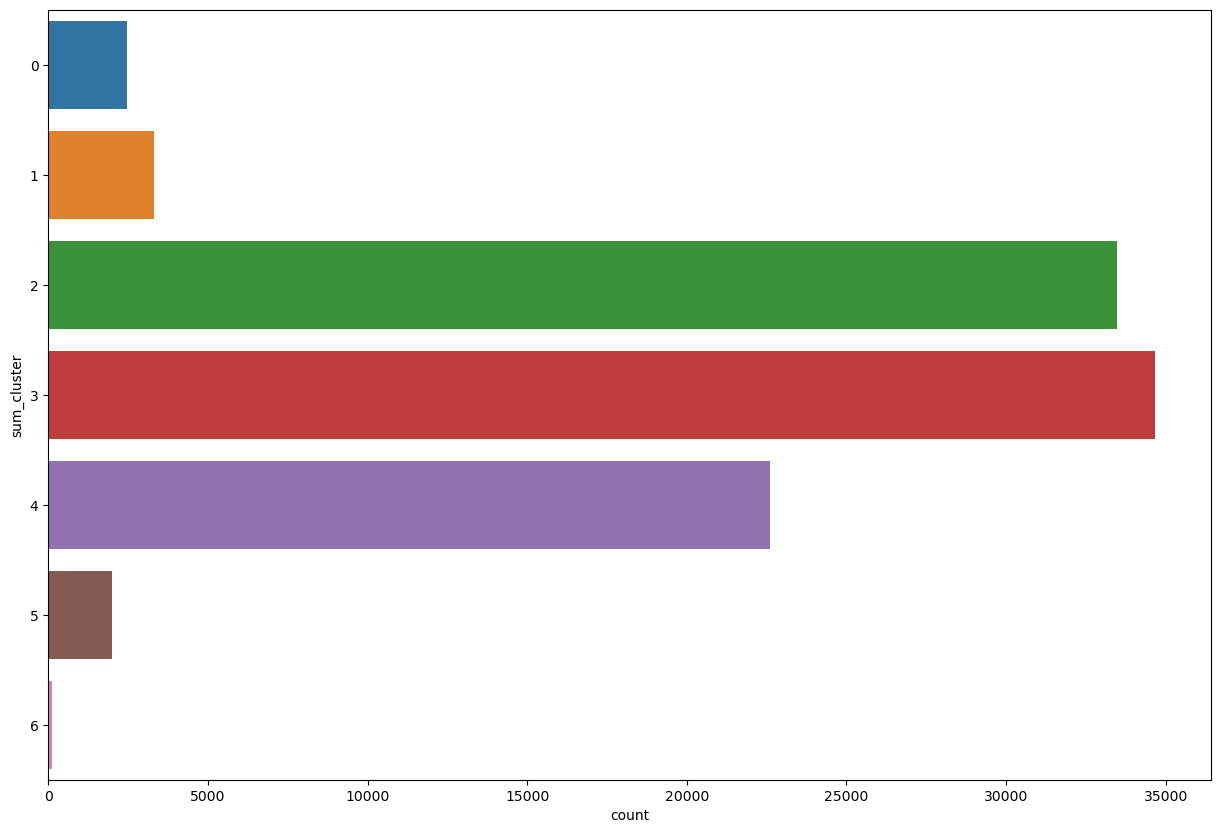

In [59]:
#смортим на распределение суммированных скоров
plt.figure(figsize = (15, 10))
sns.countplot(y = rfm['sum_cluster'])

<AxesSubplot:xlabel='count', ylabel='compile_cluster'>

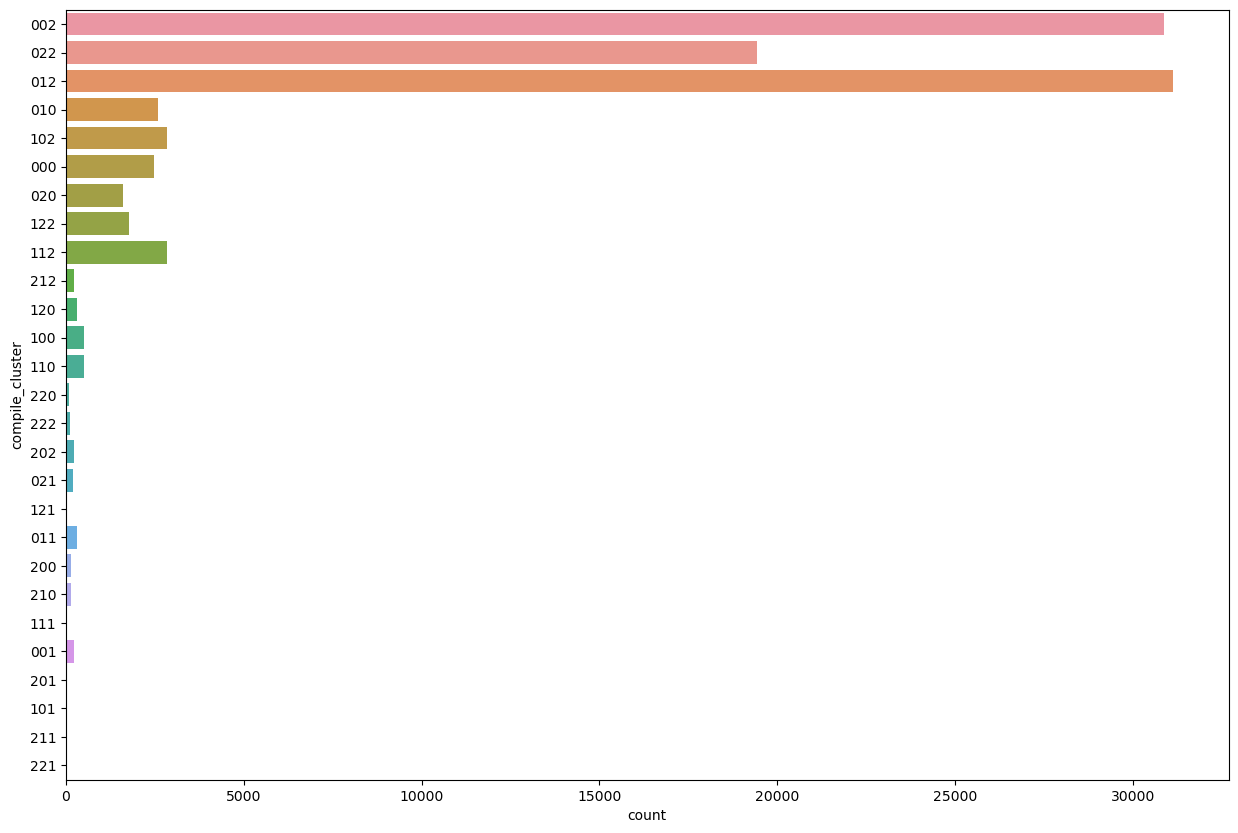

In [58]:
#смортим на распределение конкатенированных скоров
plt.figure(figsize = (15, 10))
sns.countplot(y = rfm['compile_cluster'])

Очень большой перекос из-за freq_score. Нужно больше информации по специфике бизнеса, чтобы внести коррекрировки в критерии скоров и сделать более компетентный вывод